# Advanced Learning Algorithms

### What to try next?

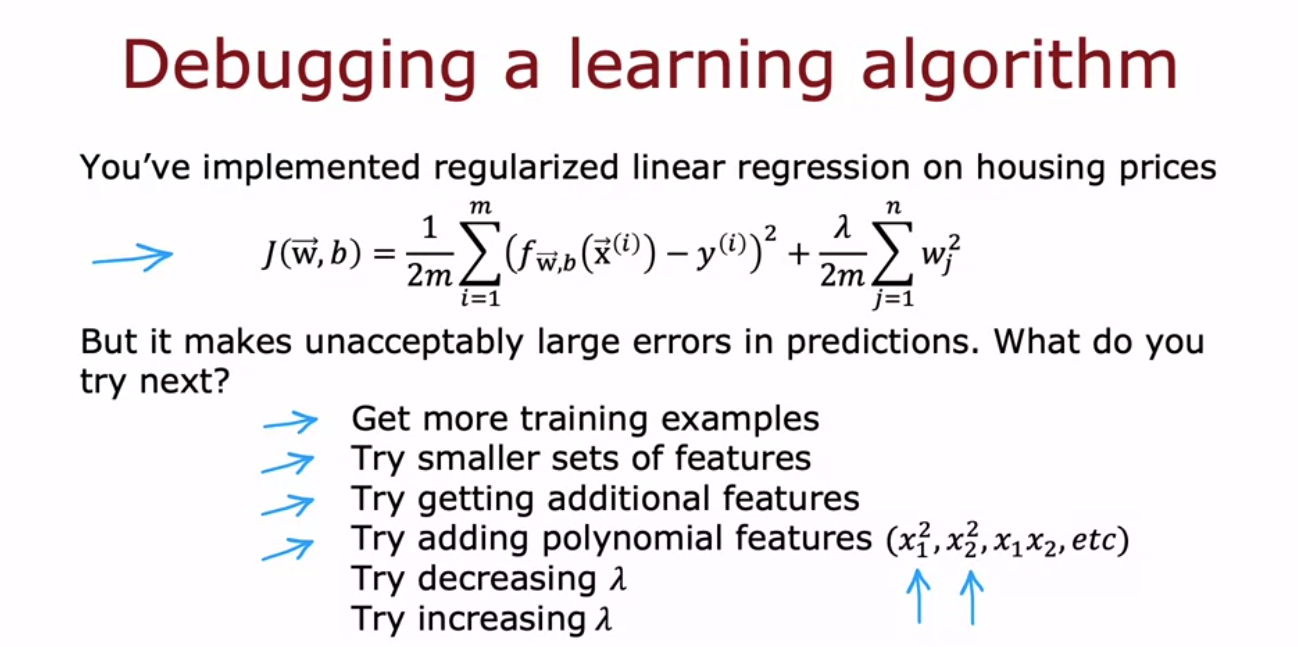


- For fixing high variance
    - Get more training examples
    - Smaller set of features
    - Increase lambda

- For fixing high bias
    - Get additional features
    - Adding more polynomial features
    - Decrease lambda

### Holdout test set

Leave a part of data for testing generalization. Don't consider regularization when calculating test and training error, only in the cost function that will be optimized.

#### Regressão
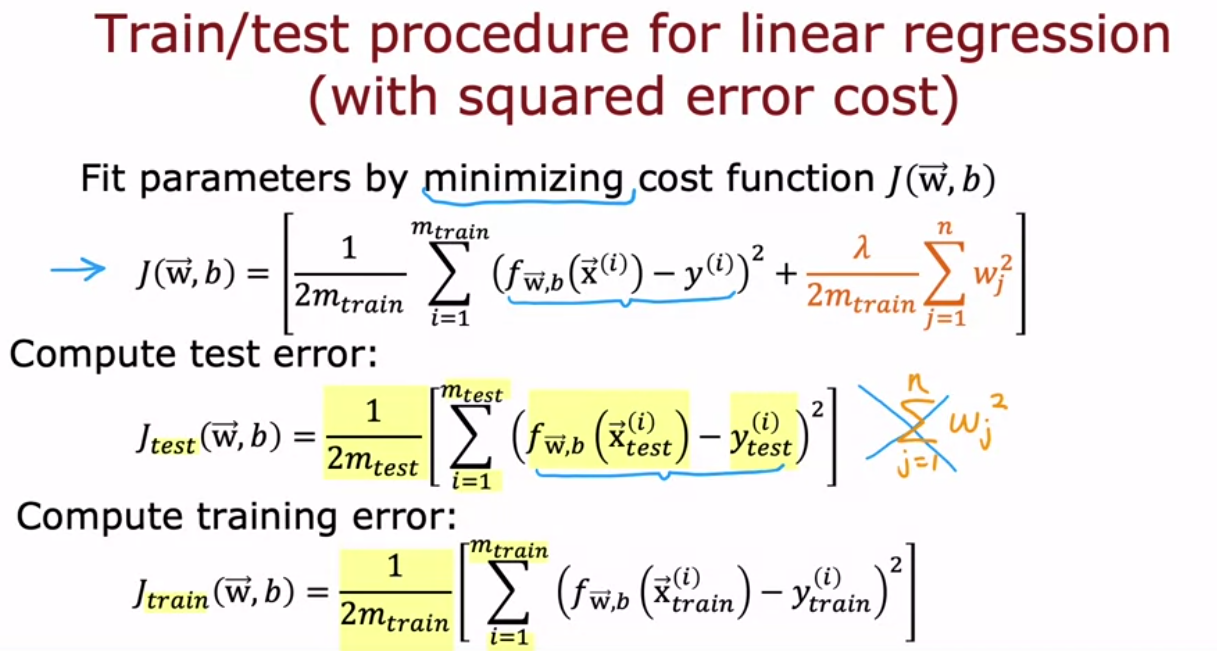

#### Classificação

Using log loss is not prefered to calculate train and test errors. Instead we can calculate the amount of examples the algorithm misclassified.

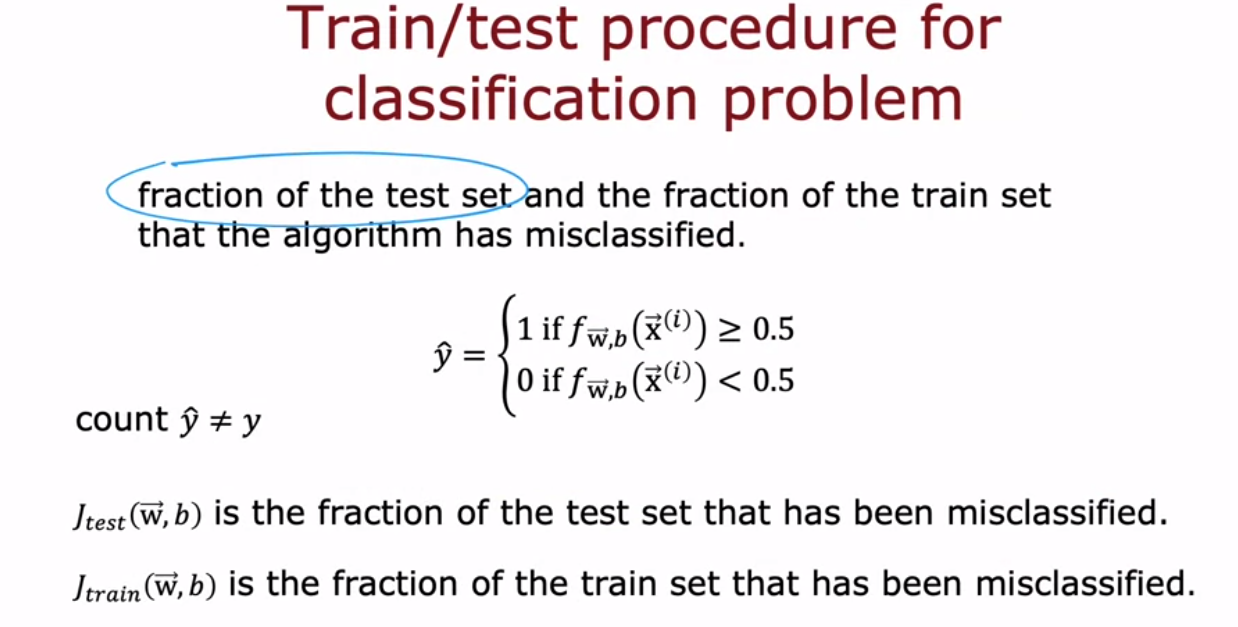

### Training/(cross) validation/test set

Choose hyperparameters based on validation error and not test error. It's bad to make choices based on test set, because its use is only to give the final generalizaton error.

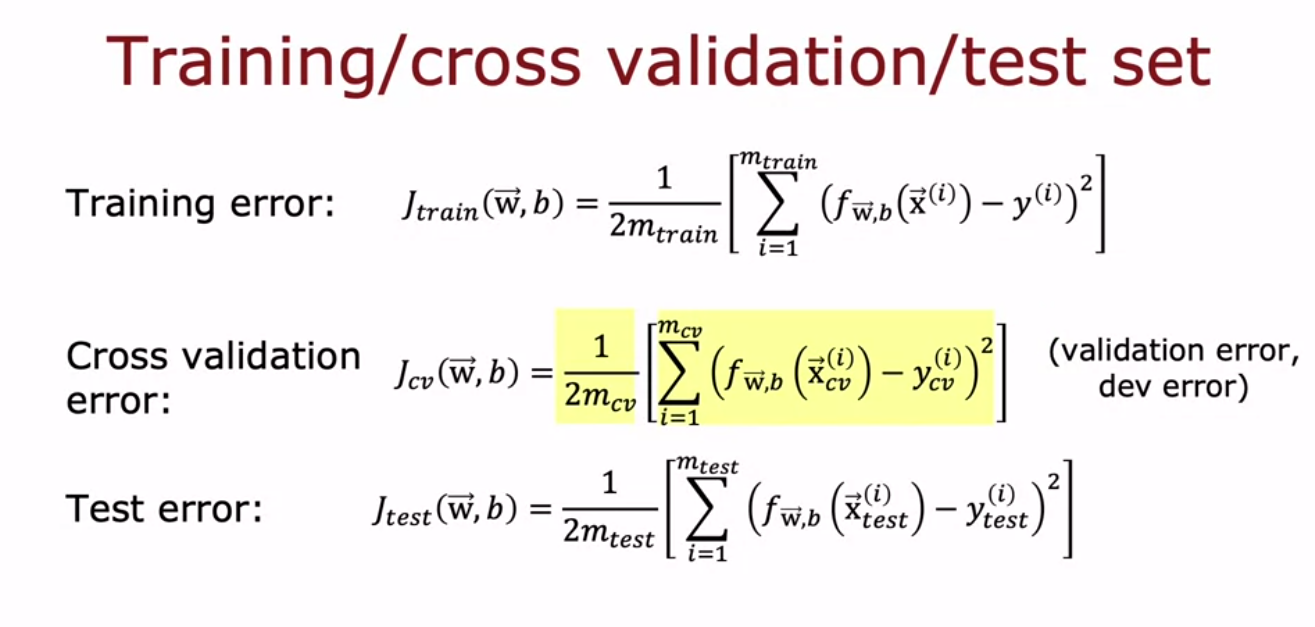

**Use scikitlearn cross_val_score() or get best score from GridSearchCV, RandomSearchCV or bayesian hyperparameter optimization methods (optuna, hyperopt)**

### Bias/variance tradeoff

We diagnose the bias/variance on the loss of training and validation sets.

**Regularization parameter lambda can help reach bias/variance trade-off.**

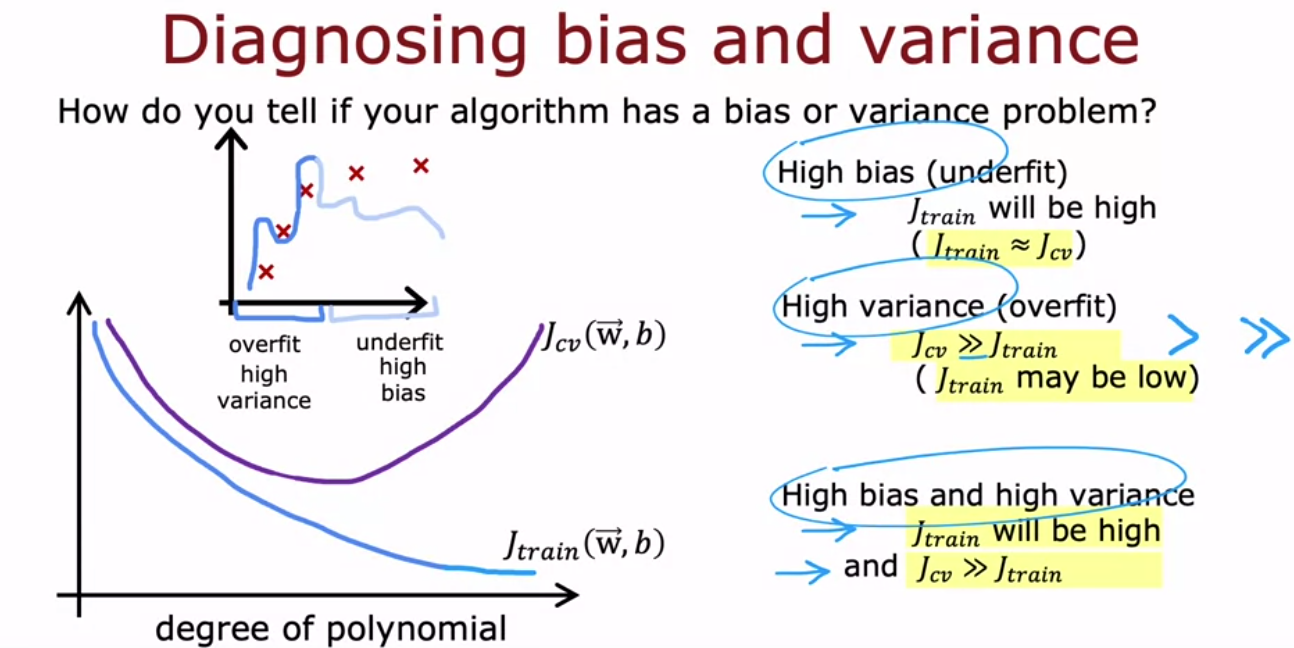

### Estabilishing a baseline level of performance
- What's baseline level of performance can you reasonably hope from your model? You can set baselines, such as:
    - Human level perforamnce
    - Competing algorithms performance
    - Guess based on experience

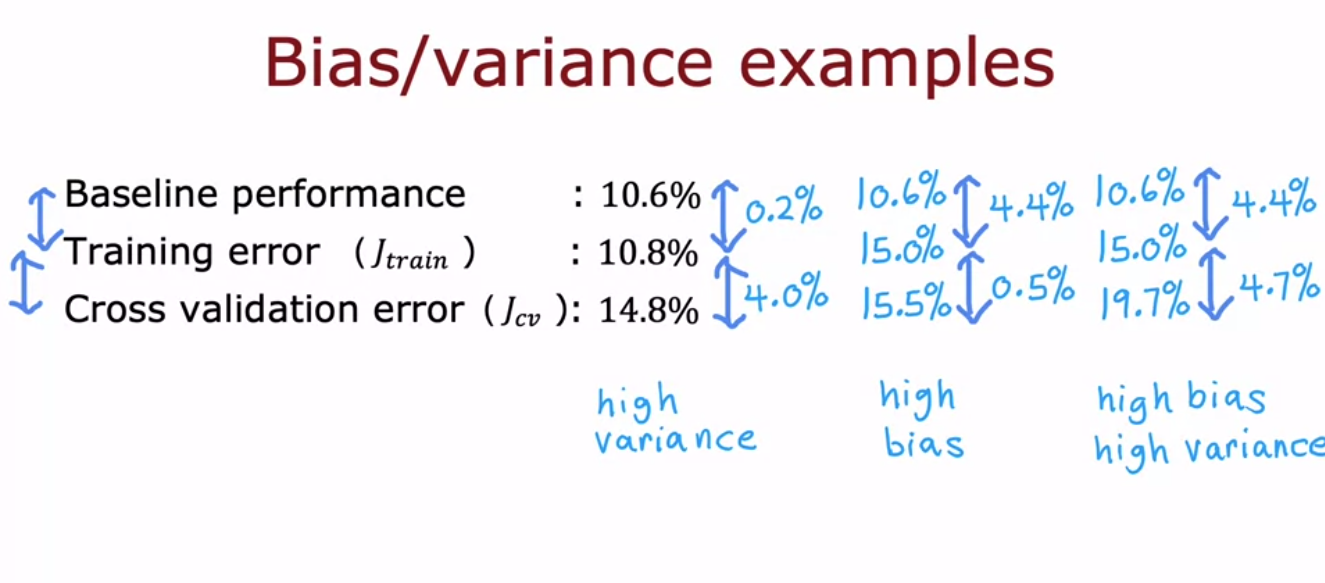

### Learning curves


**A model with high bias will NOT benefit from more data.**

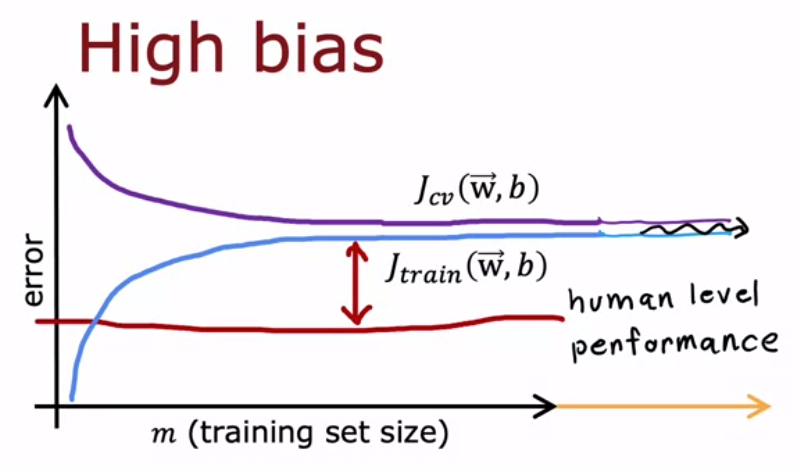

**A model with high variance LIKELY benefits from more data.**

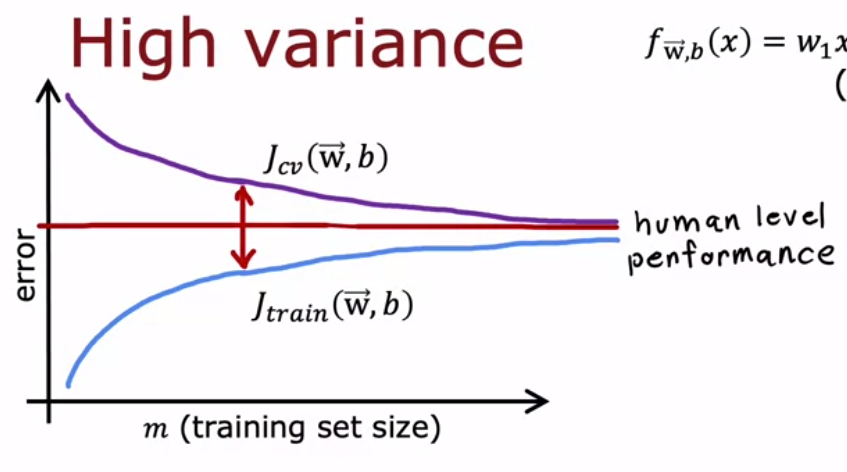

In [10]:
import pandas as pd
import numpy as np
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [34]:
def prepare_dataset(filename):
    
    data = np.loadtxt(filename, delimiter=",")
    
    x = data[:,:-1]
    y = data[:,-1]
    
    # Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
    x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=80)

    # Split the 40% subset above into two: one half for cross validation and the other for the test set
    x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)
    
    return x_train, y_train, x_cv, y_cv, x_test, y_test

def train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for reg_param in reg_params:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model = Ridge(alpha=reg_param)
        model.fit(X_train_mapped_scaled, y_train)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    reg_params = [str(x) for x in reg_params]
    plt.plot(reg_params, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(reg_params, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(reg_params, np.repeat(baseline, len(reg_params)), linestyle='--', label='baseline')
    plt.title("lambda vs. train and CV MSEs")
    plt.xlabel("lambda"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

def train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    degrees = range(1,max_degree+1)

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for degree in degrees:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train )
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree of polynomial"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

def train_plot_learning_curve(model, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    num_samples_train_and_cv = []
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for percent in percents:
        
        num_samples_train = round(len(x_train) * (percent/100.0))
        num_samples_cv = round(len(x_cv) * (percent/100.0))
        num_samples_train_and_cv.append(num_samples_train + num_samples_cv)
        
        x_train_sub = x_train[:num_samples_train]
        y_train_sub = y_train[:num_samples_train]
        x_cv_sub = x_cv[:num_samples_cv]
        y_cv_sub = y_cv[:num_samples_cv]

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train_sub)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train_sub)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train_sub, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv_sub)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv_sub, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(num_samples_train_and_cv, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(num_samples_train_and_cv, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(num_samples_train_and_cv, np.repeat(baseline, len(percents)), linestyle='--', label='baseline')
    plt.title("number of examples vs. train and CV MSEs")
    plt.xlabel("total number of training and cv examples"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

Fixing High Bias
- Try adding polynomial features

the shape of the training set (input) is: (60, 1)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 1)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (1 feature):
 [[3757.57575758]
 [2878.78787879]
 [3545.45454545]
 [1575.75757576]
 [1666.66666667]]



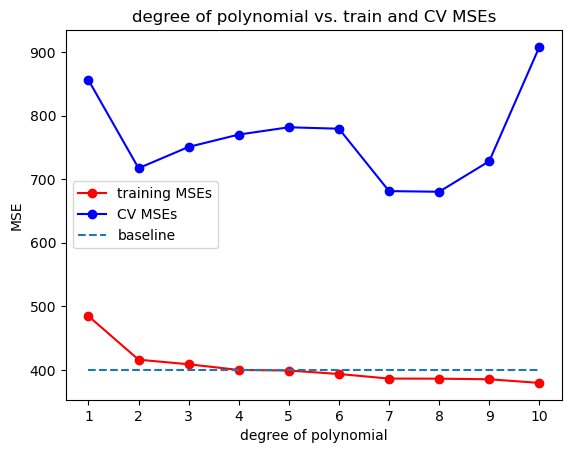

In [35]:
# Split the dataset into train, cv, and test
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('c2w3_lab2_data1.csv')

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (1 feature):\n {x_train[:5]}\n")

# Instantiate the regression model class
model = LinearRegression()

# Train and plot polynomial regression models
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=400)

As you can see, the more polynomial features you add, the better the model fits to the training data. In this example, it even performed better than the baseline. At this point, you can say that the models with degree greater than 4 are low-bias because they perform close to or better than the baseline.

However, if the baseline is defined lower (e.g. you consulted an expert regarding the acceptable error), then the models are still considered high bias. You can then try other methods to improve this.

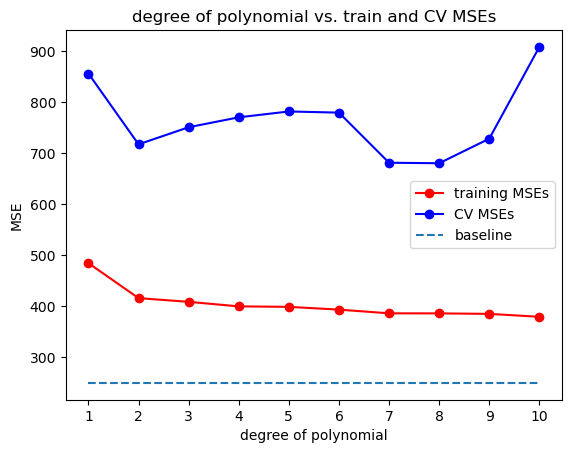

In [19]:
# Train and plot polynomial regression models. Bias is defined lower.
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=250)

Add more features, now 2

In [29]:
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('c2w3_lab2_data2.csv')

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (2 features):\n {x_train[:5]}\n")

the shape of the training set (input) is: (60, 2)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 2)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (2 features):
 [[3.75757576e+03 5.49494949e+00]
 [2.87878788e+03 6.70707071e+00]
 [3.54545455e+03 3.71717172e+00]
 [1.57575758e+03 5.97979798e+00]
 [1.66666667e+03 1.61616162e+00]]



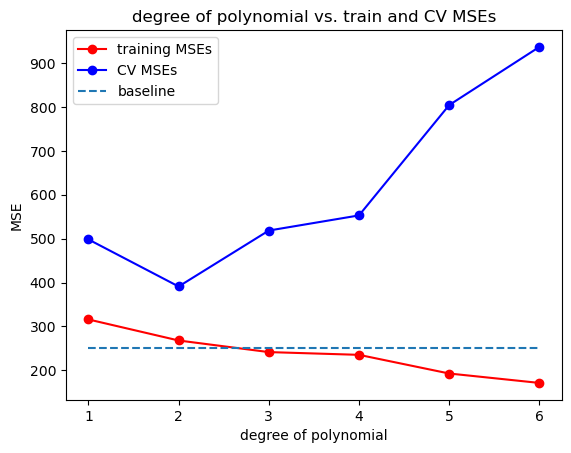

In [25]:
# Instantiate the model class
model = LinearRegression()

# Train and plot polynomial regression models. Dataset used has two features.
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=6, baseline=250)

Training error is better with more features when bias is high

- Try decreasing the regularization parameter

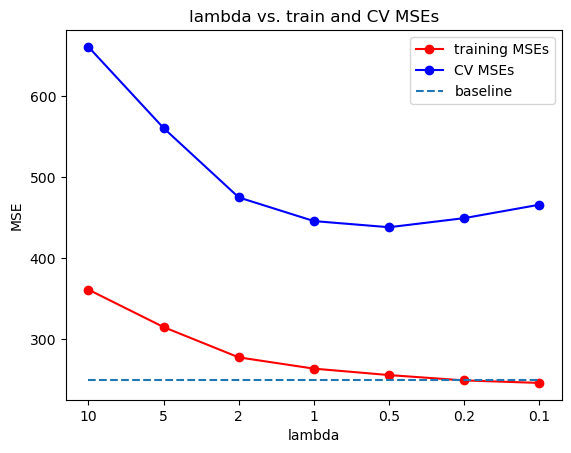

In [30]:
# Define lambdas to plot
reg_params = [10, 5, 2, 1, 0.5, 0.2, 0.1]

# Define degree of polynomial and train for each value of lambda
train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

Fixing high variance (high CV mse compared to training MSE)
- Try increasing the regularization parameter
- Try smaller sets of features
- Get more training examples

the shape of the entire training set (input) is: (600, 2)
the shape of the entire training set (target) is: (600,)

the shape of the entire cross validation set (input) is: (200, 2)
the shape of the entire cross validation set (target) is: (200,)



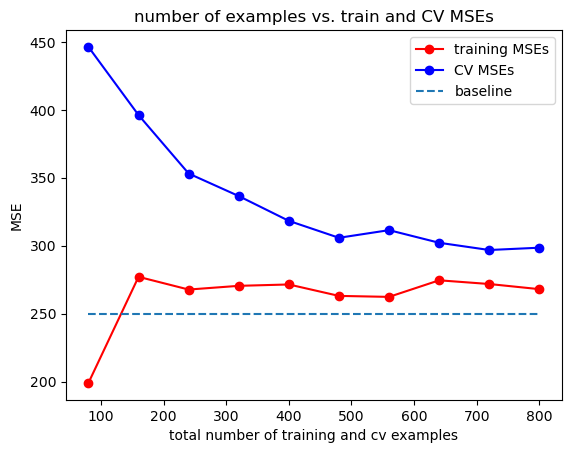

In [37]:
# GET MORE TRAINING EXAMPLES
# Prepare the dataset
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('c2w3_lab2_data4.csv')
print(f"the shape of the entire training set (input) is: {x_train.shape}")
print(f"the shape of the entire training set (target) is: {y_train.shape}\n")
print(f"the shape of the entire cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the entire cross validation set (target) is: {y_cv.shape}\n")

# Instantiate the model class
model = LinearRegression()

# Define the degree of polynomial and train the model using subsets of the dataset.
train_plot_learning_curve(model, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

### Bias/variance in neural networks

Large neural networks are low bias machines. Make neural network bigger and bigger, test if it does well in validation set. A large neural network will usually do as well or better than a smaller one so long as regularization is chosen properly.

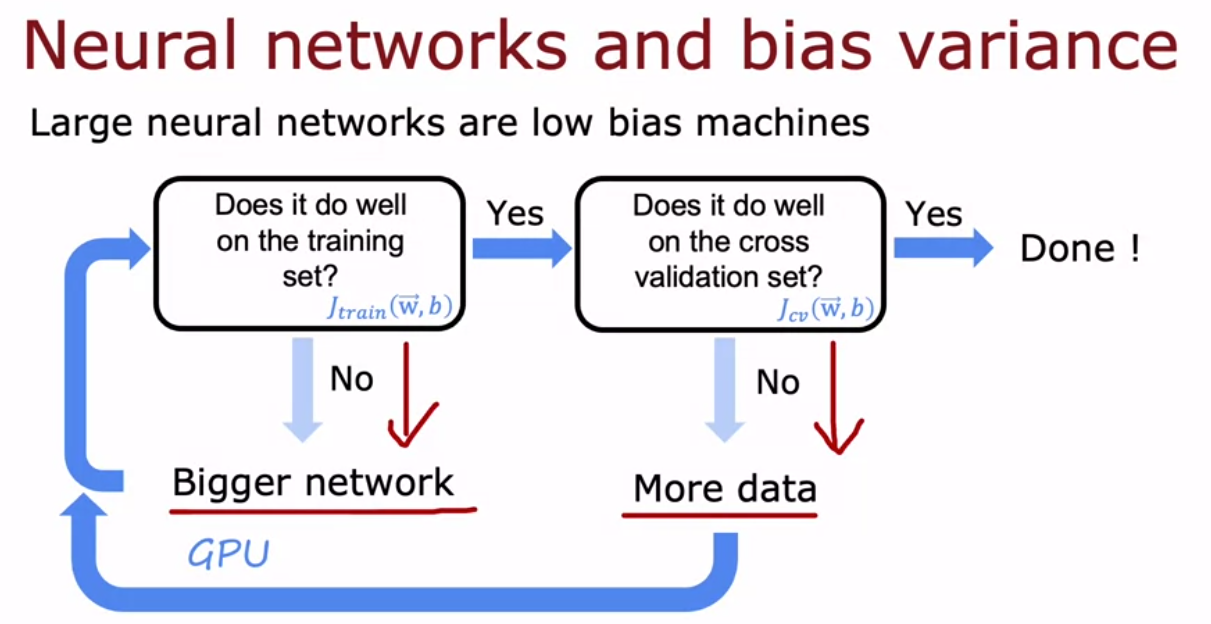


### Iterative loop of ML development

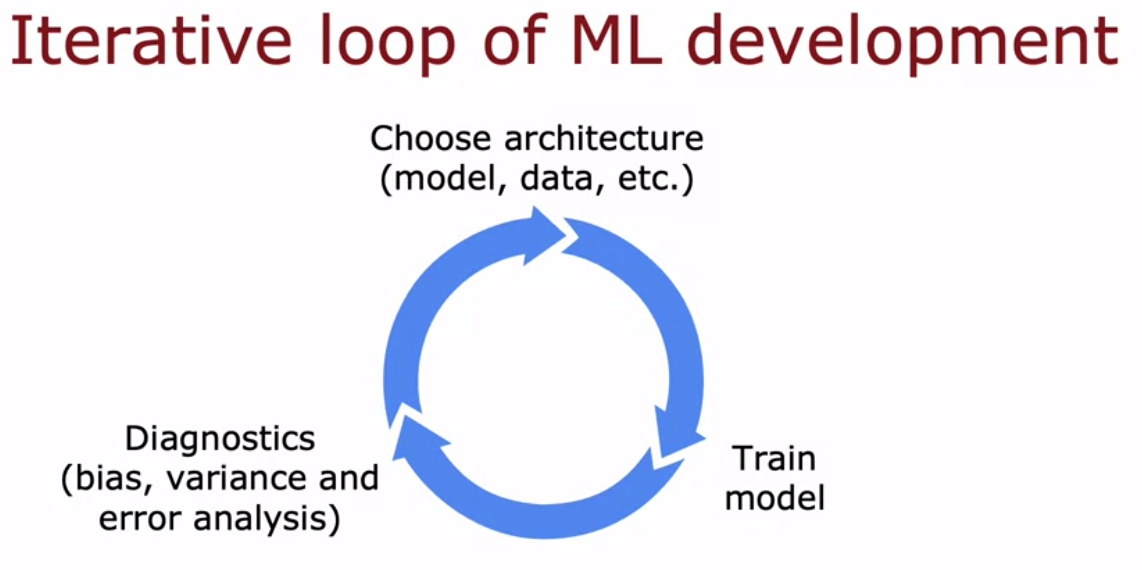

### Full cycle of a ML project

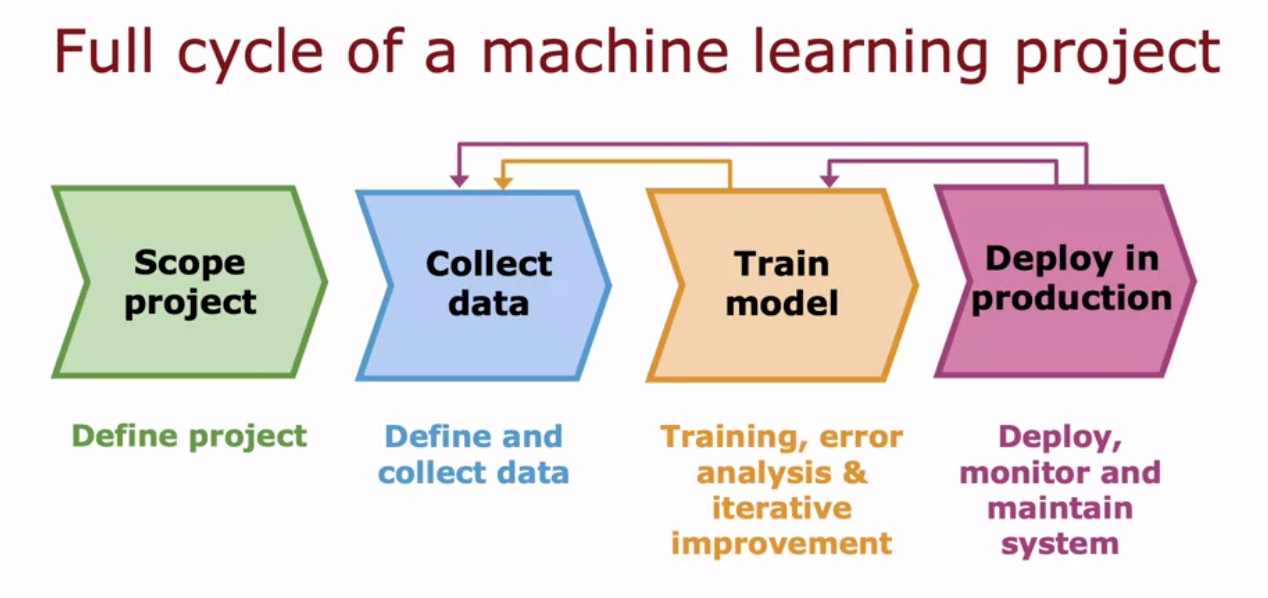

### Transfer learning

Transfer learning involves taking a pre-trained model trained on a large dataset and applying it to a new task that may have a different dataset but is related to the original task. Often involves further training of the model with a small dataset with frozen layers (except last).

#### Fine tuning
Fine-tuning involves taking a pre-trained model and further training it on a new dataset, often with a small learning rate, to adapt it to the specifics of the new task.



### Error metrics for skewed datasets

- Recall and precision tradeoff
- Use f1 score on test data (picks the best precision/recall tradeoff)

- check precision-recall curve

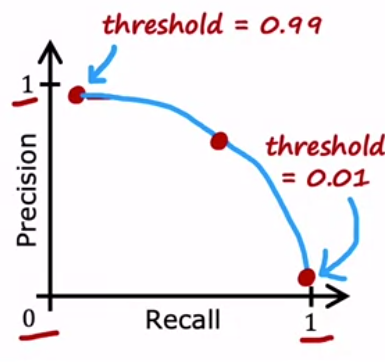